# <span style="font-family:Verdana;"> Google - Isolated Sign Language Recognition: Baseline Model </span>

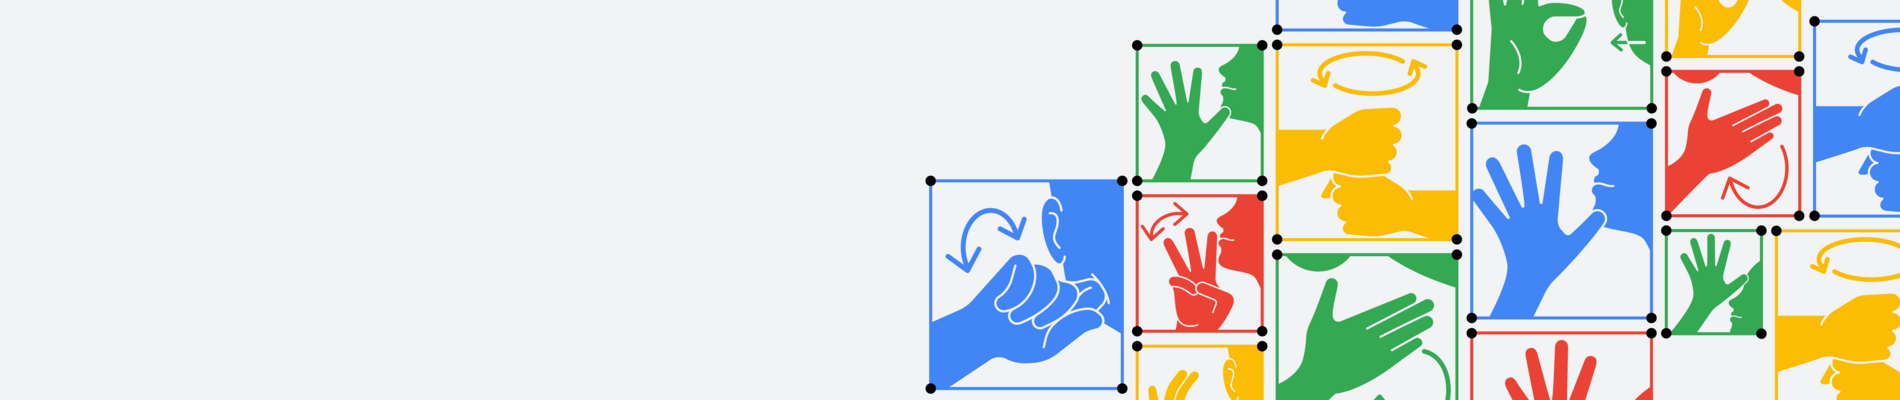
****

<span style="font-family:Verdana;">  📌 The goal of this notebook is to build a baseline ASL recognition engine using the average frames dataset. We will be leveraging the modularity of the custom keras layer to apply some preprocessing steps to the 3D landarks and for feature extraction. In effect, we will be appllying different layers to specific landarks as explained below: </span>

<span style="font-family:Verdana;">
    
1. The `ChooseHand` layer is responsible of only extracting the signing hand in the frames 
2. The `GatherLayer` layer can extract specific landarks (upper and lower lips) given a set of indices
3. The `HandKineticLayer` layer is responsible of calculating the euclidean distance between non-consecutive joints of the signing hand
4. The `FaceKineticLayer` layer will calculate the euclidean distance between non-consecutive joints of upper and lower lips
5. The `AngularLayer` layer will compute the angle between the x and y vectors between non-consecutive joints of the hand
</span>

<span style="font-family:Verdana;"> By following this strategy, we ensure an efficient feature extraction process (distance and angle based features), providing the model with the right information to accurately differentiate between the 250 signs.    </span>


## <span style="font-family:Verdana;"> Proposed Strategy </span>

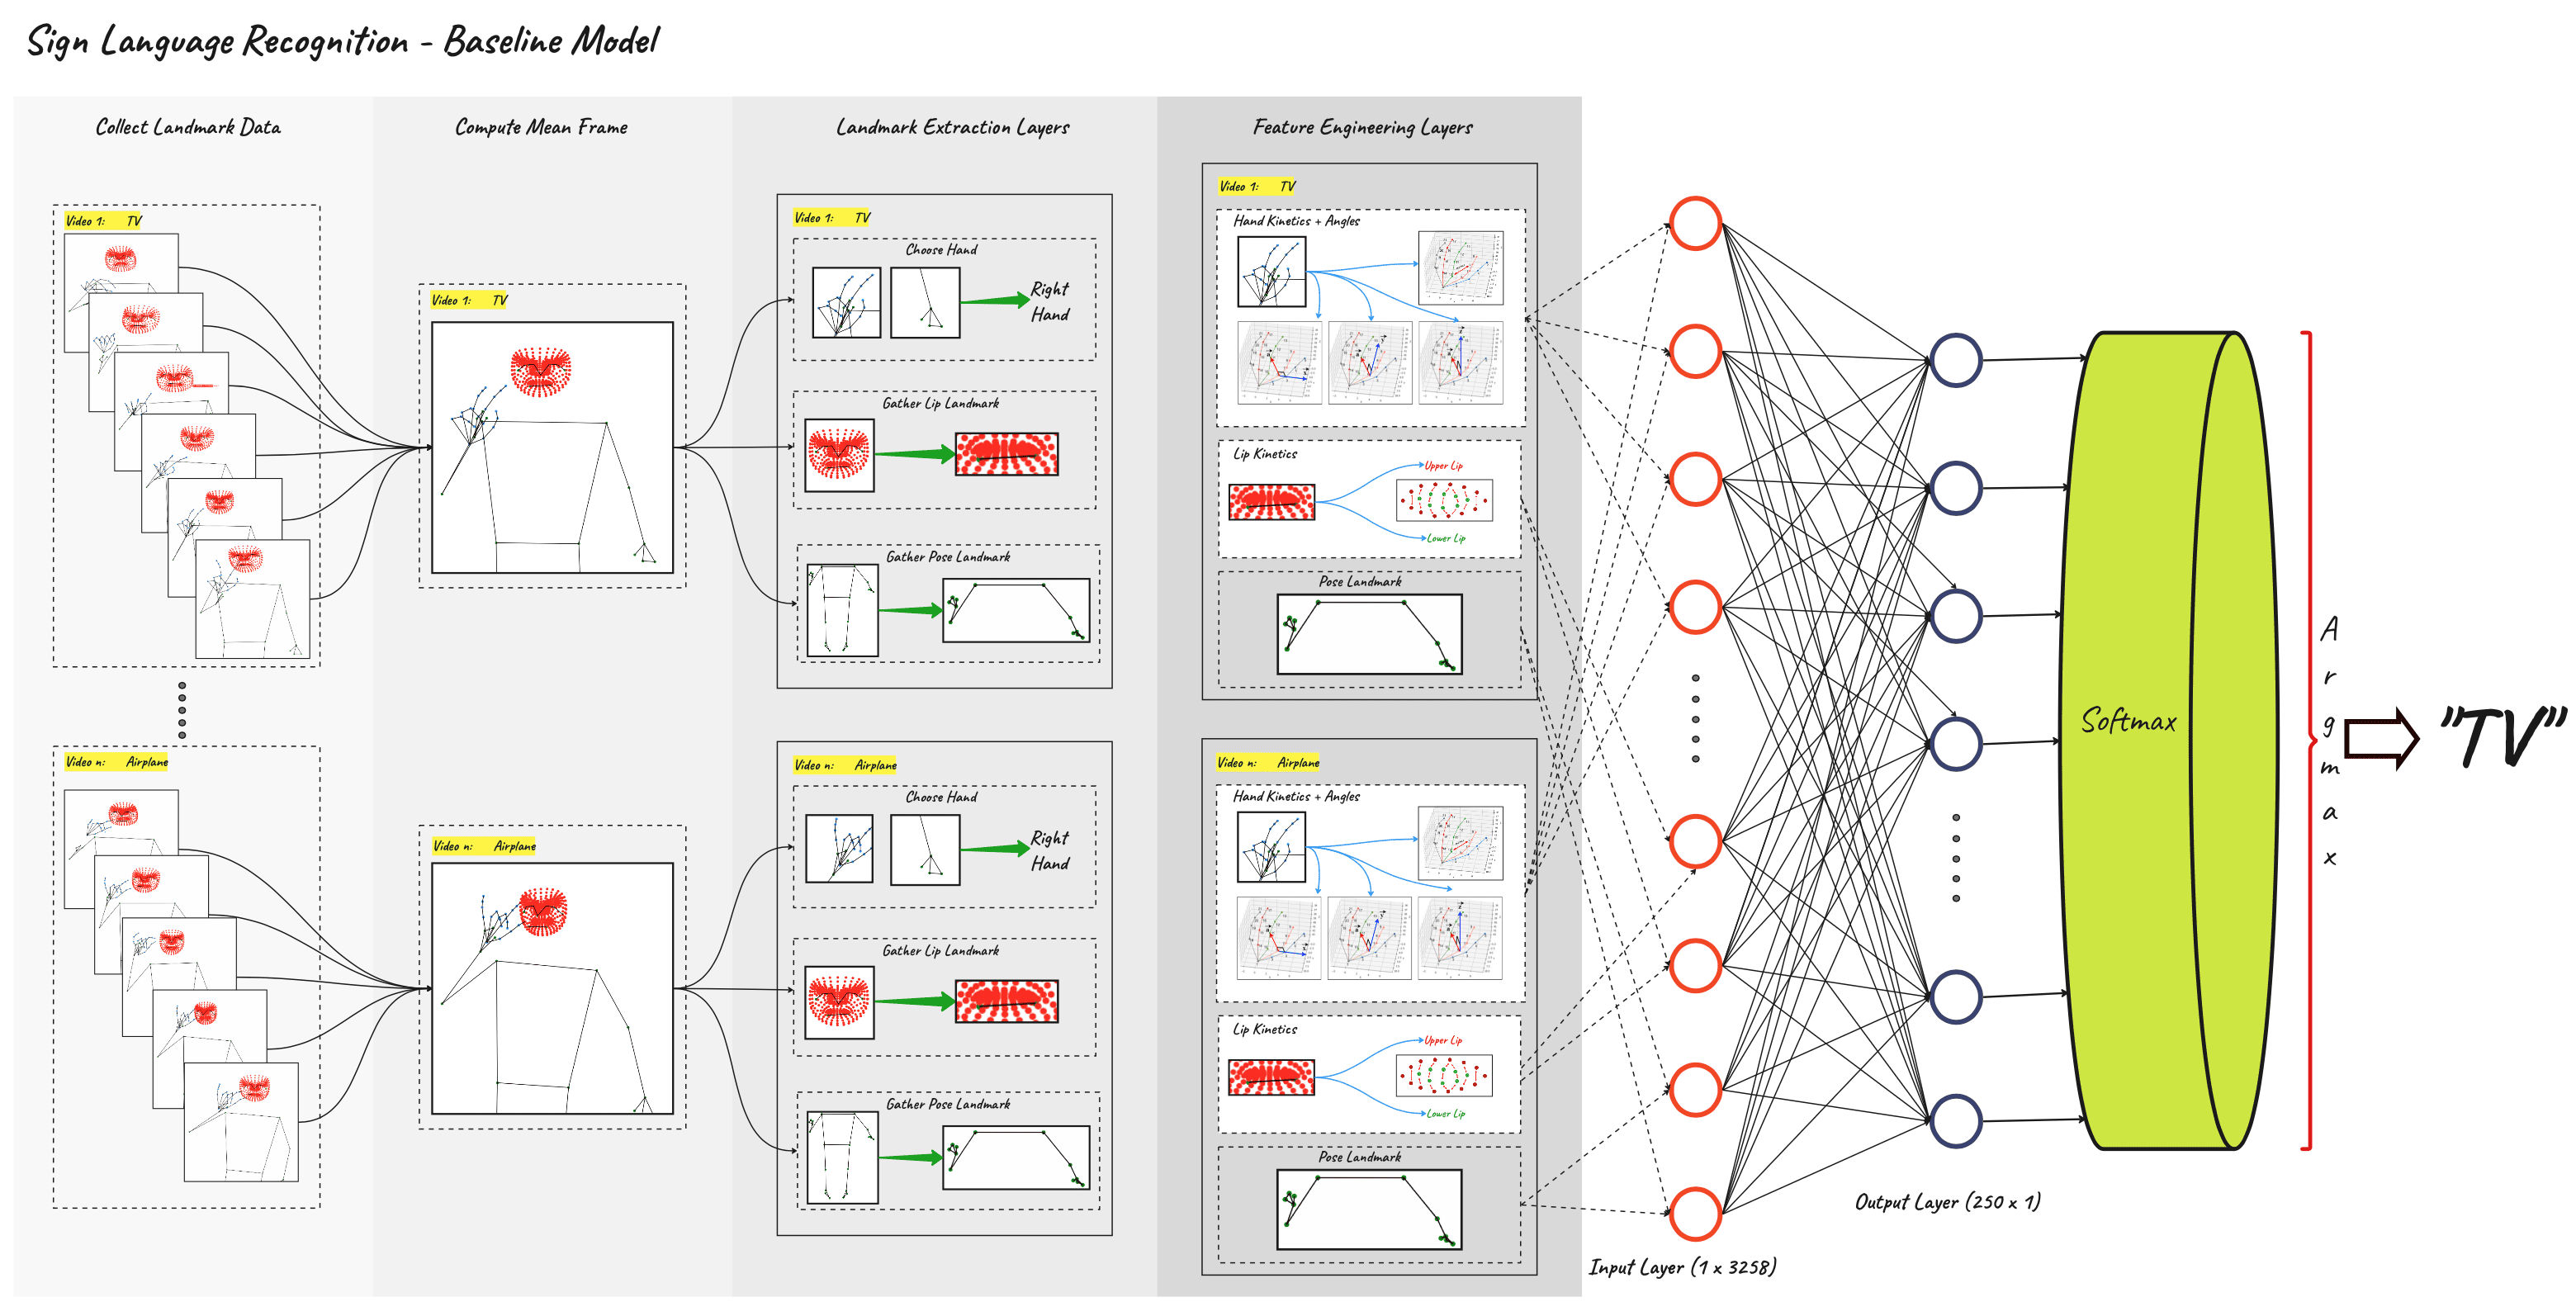
****

### <span style="font-family:Verdana;"> Import Packages </span>

In [1]:
# Machine Learning and Data Science Imports (basics)
import tensorflow as tf
import random
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import numpy as np
import os
from tqdm.notebook import tqdm; tqdm.pandas();
import plotly.express as px
from PIL import Image, ImageEnhance; Image.MAX_IMAGE_PIXELS = 5_000_000_000;
from matplotlib import animation, rc; rc('animation', html='jshtml')
import json
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import plotly.io as pio
pio.templates.default = "simple_white"
import math

def seed_it_all(seed=42):
    """ Attempt to be Reproducible """
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_it_all()

from feature_engineering import *
from helper_functions import *

## <span style="font-family:Verdana;"> Exploratory Analysis</span>

In [2]:
# import data from specified data directory
def load_json_file(json_path):
    with open(json_path, 'r') as f:
        sign_map = json.load(f)
    return sign_map

class CFG:
    data_dir = "/kaggle/input/asl-signs/"
    sequence_length = 12
    rows_per_frame = 543

ROWS_PER_FRAME = 543
def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)
    
sign_map = load_json_file(CFG.data_dir + 'sign_to_prediction_index_map.json')
train_data = pd.read_csv(CFG.data_dir + 'train.csv')

s2p_map = {k.lower():v for k,v in load_json_file(CFG.data_dir + "sign_to_prediction_index_map.json").items()}
p2s_map = {v:k for k,v in load_json_file(CFG.data_dir + "sign_to_prediction_index_map.json").items()}
encoder = lambda x: s2p_map.get(x.lower())
decoder = lambda x: p2s_map.get(x)

# inspect data from one parquet file
train_data.head()

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


In [3]:
# check that each file is unique (no duplicates)
print(f'Do we have unique path for every file? {train_data.path.nunique() == len(train_data)}')
print(f'Number of total ASL files: {len(train_data)}')
print(f'Number of unique participants: {train_data.participant_id.nunique()}')
print(f'Do we have at least one file for each sign provided? {train_data.sign.nunique() == len(sign_map)} ')
print(f'Number of total classes: {train_data.sign.nunique()}')
print(f"Let's see how balanced our training dataset is between the different classes")
fig = px.histogram(train_data, x="sign", color_discrete_sequence=["royalblue"],
                   labels={'sign':'ASL sign'}).update_xaxes(categoryorder="total ascending")
fig.show()

Do we have unique path for every file? True
Number of total ASL files: 94477
Number of unique participants: 21
Do we have at least one file for each sign provided? True 
Number of total classes: 250
Let's see how balanced our training dataset is between the different classes


### <span style="font-family:Verdana;"> 2D Visualization</span>

In [4]:
# Visualization of one parquet file
parquet_df = pd.read_parquet(CFG.data_dir + train_data.path[0])
visualise_landmarks(parquet_df).show()

## <span style="font-family:Verdana;"> Model Pipeline</span>

### <span style="font-family:Verdana;"> Load Mean Dataset</span>

In [5]:
from sklearn.preprocessing import normalize
train_x = np.load("/kaggle/input/gislr-feature-data/feature_data.npy").astype(np.float32)
train_y = np.load("/kaggle/input/gislr-feature-data/feature_labels.npy").astype(np.uint8)

N_TOTAL = train_x.shape[0]
VAL_PCT = 0.1
N_VAL   = int(N_TOTAL*VAL_PCT)
N_TRAIN = N_TOTAL-N_VAL

random_idxs = random.sample(range(N_TOTAL), N_TOTAL)
train_idxs, val_idxs = np.array(random_idxs[:N_TRAIN]), np.array(random_idxs[N_TRAIN:])

val_x, val_y = train_x[val_idxs], train_y[val_idxs]
train_x, train_y = train_x[train_idxs], train_y[train_idxs]

### <span style="font-family:Verdana;"> Feature Engineering with Custom Keras Layers </span>

In [6]:
# Gather specific landmarks
class GatherLayer(tf.keras.layers.Layer):
    def __init__(self, indices, **kwargs):
        super(GatherLayer, self).__init__(**kwargs)
        self.indices = indices
        
    def call(self, inputs):
        return tf.gather(inputs, tf.cast(self.indices, dtype=tf.int32), axis=1)

# Find main hand and extract it
class ChooseHand(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def call(self, inputs):
        hand_inputs_final = []
        for s in range(inputs.shape[0]):
            left_hand_inputs = inputs[s, 1404:1467]
            right_hand_inputs = inputs[s, 1566:1629]
            hand_inputs = tf.cond(tf.equal(tf.reduce_sum(tf.abs(left_hand_inputs)), 0),
                              lambda: right_hand_inputs,
                              lambda: left_hand_inputs)
            hand_inputs_final.append(hand_inputs)
        stacked_hand_inputs = tf.stack(hand_inputs_final, axis=-1)
        transposed_hand_inputs = tf.transpose(stacked_hand_inputs, perm=[1, 0])
        return transposed_hand_inputs

# Calculate distance between non-consecutive joints in main hand
class HandKineticLayer(tf.keras.layers.Layer):
    
    def __init__(self, **kwargs):
        super().__init__()
    
    def call(self, tensor):
        end_ldmrk = [4*3,8*3,12*3,16*3, 19*3]
        for index in range(0, 60, 3):
            start = (index+3) if index in end_ldmrk else (index+6)
        
            dist_list = []
            for x in range(start, 63, 3):
                dx = tensor[:,index] - tensor[:,x]
                dy = tensor[:,index+1] - tensor[:,x+1]
                dist = tf.sqrt(tf.square(dx) + tf.square(dy))
                dist_list.append(dist)
                
            dist_tensor = tf.stack(dist_list, axis=-1)
            tensor = tf.concat([tensor, dist_tensor], axis=-1)
        return tensor
    
# Calculate distance between non-consecutive joints in lips
class FaceKineticLayer(tf.keras.layers.Layer):
    
    def __init__(self, **kwargs):
        super().__init__()
    
    def call(self, tensor):
        for index in range(0, 36, 2):
            start = (index+4)
            
            dist_list = []
            for x in range(start, 40, 2):
                dx = tensor[:,index] - tensor[:,x]
                dy = tensor[:,index+1] - tensor[:,x+1]
                dist = tf.sqrt(tf.square(dx) + tf.square(dy))
                dist_list.append(dist)
            
            dist_tensor = tf.stack(dist_list, axis=-1)
            tensor = tf.concat([tensor, dist_tensor], axis=-1)
        return tensor

# Calculate angle between non-consecutive joints in main hand
class AngularLayer(tf.keras.layers.Layer):
    
    def __init__(self, **kwargs):
        super().__init__()
    
    def call(self, tensor):
        for index in range(0, 60, 3):
            start = (index+3) 
            angle_list = []
            for j in range(start, 63, 3):
                vector = tensor[:, j:j+2] - tensor[:, index:index+2] 
                norms = tf.norm(vector, axis=1)
                x_tilt = (tf.clip_by_value(vector[:, 0]/norms, -1.0, 1.0))
                y_tilt = (tf.clip_by_value(vector[:, 1]/norms, -1.0, 1.0))
                angle = tf.stack([x_tilt, y_tilt], axis=1)
                angle_list.append(angle)
            angle_tensor = tf.concat(angle_list, axis=-1)
            tensor = tf.concat([tensor, angle_tensor], axis=-1)
            tensor = tf.cast(tensor, tf.float32)
        return tensor

## <span style="font-family:Verdana;"> Build Model Architecture </span>

In [7]:
def DenseLayer(inputs, nn, dropout):
    x = tf.keras.layers.Dense(nn)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("gelu")(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    return x

def build_model1():
    batch_size = 64

    inputs = tf.keras.Input(batch_shape=(batch_size,) + (3258,), dtype=tf.float32)
    hand_inputs = ChooseHand()(inputs) 
    hand_inputs = HandKineticLayer()(hand_inputs)  
    hand_inputs = AngularLayer()(hand_inputs)
    hand_coord = hand_inputs[:, :42]
    hand_features = hand_inputs[:, 63:]
    hand_inputs = tf.keras.layers.Concatenate(axis=1)([hand_coord, hand_features])
    
    lower_lip_indices = [78*3, 191*3, 80*3, 81*3, 82*3, 13*3, 312*3, 311*3, 310*3, 415*3,
            95*3, 88*3, 178*3, 87*3, 14*3, 317*3, 402*3, 318*3, 324*3, 308*3,
            78*3+1, 191*3+1, 80*3+1, 81*3+1, 82*3+1, 13*3+1, 312*3+1, 311*3+1, 310*3+1, 415*3+1,
            95*3+1, 88*3+1, 178*3+1, 87*3+1, 14*3+1, 317*3+1, 402*3+1, 318*3+1, 324*3+1, 308*3+1]
    
    upper_lip_indices = [61*3, 185*3, 40*3, 39*3, 37*3, 0, 267*3, 269*3, 270*3, 409*3,
            291*3, 146*3, 91*3, 181*3, 84*3, 17*3, 314*3, 405*3, 321*3, 375*3,
            61*3+1, 185*3+1, 40*3+1, 39*3+1, 37*3+1, 0+1, 267*3+1, 269*3+1, 270*3+1, 409*3+1,
            291*3+1, 146*3+1, 91*3+1, 181*3+1, 84*3+1, 17*3+1, 314*3+1, 405*3+1, 321*3+1, 375*3+1]
    
    lower_lip_inputs = GatherLayer(lower_lip_indices)(inputs)
    lower_lip_inputs = FaceKineticLayer()(lower_lip_inputs)
    
    upper_lip_inputs = GatherLayer(upper_lip_indices)(inputs)
    upper_lip_inputs = FaceKineticLayer()(upper_lip_inputs)
    
    upper_body_indices = [16*3, 14*3, 12*3, 11*3, 13*3, 15*3,
                          16*3+1, 14*3+1, 12*3+1, 11*3+1, 13*3+1, 15*3+1]
    pose_inputs = GatherLayer(upper_body_indices)(inputs)
    
    all_inputs = tf.keras.layers.Concatenate(axis=1)([hand_inputs, lower_lip_inputs, upper_lip_inputs, pose_inputs])
         
    vector = DenseLayer(all_inputs, 1024//2, 0.2)
    vector = DenseLayer(vector, 1024//4, 0.6)
    
    vector = tf.keras.layers.Flatten()(vector)
    output = tf.keras.layers.Dense(250, activation="softmax")(vector)
    model = tf.keras.Model(inputs=inputs, outputs=output)
    model.compile(tf.keras.optimizers.Adam(0.000333), "sparse_categorical_crossentropy", metrics="acc")
    return model

## <span style="font-family:Verdana;"> Visualize Model Architecture </span>

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(64, 3258)]         0           []                               
                                                                                                  
 choose_hand (ChooseHand)       (64, 63)             0           ['input_1[0][0]']                
                                                                                                  
 hand_kinetic_layer (HandKineti  (64, 258)           0           ['choose_hand[0][0]']            
 cLayer)                                                                                          
                                                                                                  
 angular_layer (AngularLayer)   (64, 678)            0           ['hand_kinetic_layer[0][0]'] 

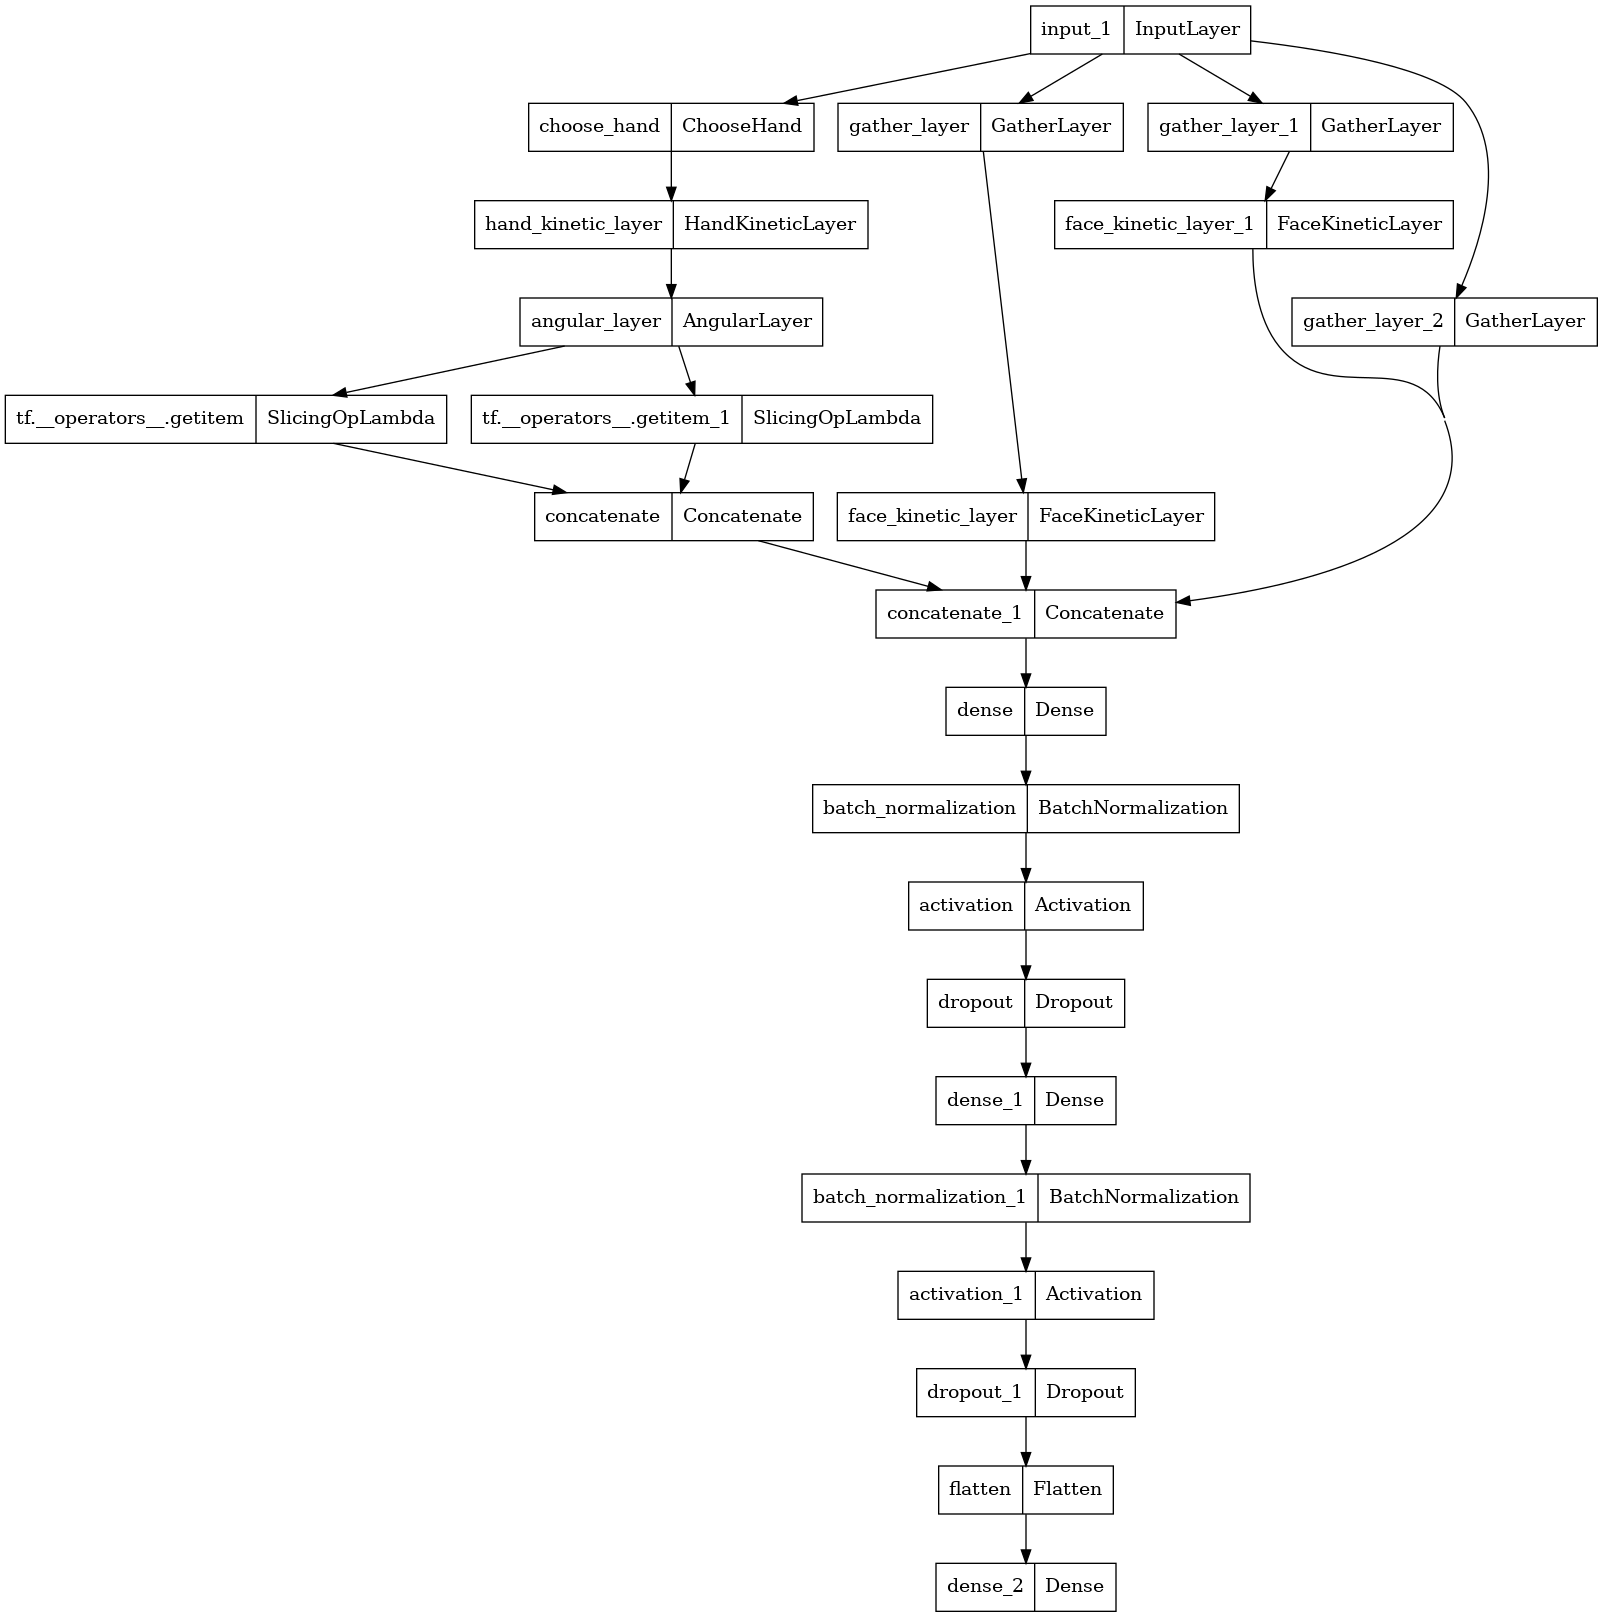

In [8]:
import keras.backend as K

K.clear_session()
model1 = build_model1()
model1.summary()
tf.keras.utils.plot_model(model1)

## <span style="font-family:Verdana;"> Model Training </span>

In [9]:
file_name = "model1"
callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            file_name, 
            save_best_only=True, 
            restore_best_weights=True, 
            monitor="val_accuracy",
            mode="max"
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor="val_accuracy",
            mode="max",
            patience=5
        ),
        tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.8, verbose=1)
    ]

train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_dataset = train_dataset.batch(batch_size=64, drop_remainder=True)
val_dataset = tf.data.Dataset.from_tensor_slices((val_x, val_y))
val_dataset = val_dataset.batch(batch_size=64, drop_remainder=True)

model1.fit(train_dataset, epochs=100, validation_data=val_dataset, batch_size=64, callbacks=callbacks)

Epoch 1/100
1328/1328 [==============================] - 71s 31ms/step - loss: 4.4134 - acc: 0.1054 - val_loss: 3.2538 - val_acc: 0.2950 - lr: 3.3300e-04
Epoch 2/100
1328/1328 [==============================] - 26s 19ms/step - loss: 3.3344 - acc: 0.2421 - val_loss: 2.7184 - val_acc: 0.3783 - lr: 3.3300e-04
Epoch 3/100
1328/1328 [==============================] - 28s 21ms/step - loss: 2.9498 - acc: 0.3119 - val_loss: 2.4732 - val_acc: 0.4178 - lr: 3.3300e-04
Epoch 4/100
1328/1328 [==============================] - 30s 23ms/step - loss: 2.7293 - acc: 0.3523 - val_loss: 2.3116 - val_acc: 0.4598 - lr: 3.3300e-04
Epoch 5/100
1328/1328 [==============================] - 27s 21ms/step - loss: 2.5820 - acc: 0.3850 - val_loss: 2.1892 - val_acc: 0.4843 - lr: 3.3300e-04
Epoch 6/100
1328/1328 [==============================] - 29s 22ms/step - loss: 2.4674 - acc: 0.4067 - val_loss: 2.0974 - val_acc: 0.5015 - lr: 3.3300e-04
Epoch 7/100
1328/1328 [==============================] - 29s 22ms/step - los

## <span style="font-family:Verdana;"> Prepare Submission </span>

### <span style="font-family:Verdana;"> Inputs Custom Layer </span>

In [10]:
class PrepInputs(tf.keras.layers.Layer):
    def __init__(self, face_idx_range=(0, 468), lh_idx_range=(468, 489), 
                 pose_idx_range=(489, 522), rh_idx_range=(522, 543)):
        super(PrepInputs, self).__init__()
        self.idx_ranges = [face_idx_range, lh_idx_range, pose_idx_range, rh_idx_range]
        self.flat_feat_lens = [3*(_range[1]-_range[0]) for _range in self.idx_ranges]
    
    def call(self, x_in):
        xs = [x_in[:, _range[0]:_range[1], :] for _range in self.idx_ranges]
        xs = [tf.reshape(_x, (-1, flat_feat_len)) for _x, flat_feat_len in zip(xs, self.flat_feat_lens)]
        
        xs[1:] = [
            tf.boolean_mask(_x, tf.reduce_all(tf.logical_not(tf.math.is_nan(_x)), axis=1), axis=0)
            for _x in xs[1:]
        ]
        
        x_means = [tf.math.reduce_mean(_x, axis=0) for _x in xs]
        x_stds  = [tf.math.reduce_std(_x,  axis=0) for _x in xs]
        
        x_out = tf.concat([*x_means, *x_stds], axis=0)
        x_out = tf.where(tf.math.is_finite(x_out), x_out, tf.zeros_like(x_out))
        return tf.expand_dims(x_out, axis=0)

### <span style="font-family:Verdana;"> TFLite Model Module </span>

In [11]:
import tensorflow as tf

class TFLiteModel(tf.Module):
    """
    TensorFlow Lite model that takes input tensors and applies:
        – a preprocessing model
        – the ISLR model 
    """

    def __init__(self, islr_model):
        """
        Initializes the TFLiteModel with the specified preprocessing model and ISLR model.
        """
        super(TFLiteModel, self).__init__()

        # Load the feature generation and main models
        self.prep_inputs = PrepInputs()
        self.islr_model = islr_model
    
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, 543, 3], dtype=tf.float32, name='inputs')])
    def __call__(self, inputs):
        """
        Applies the feature generation model and main model to the input tensors.

        Args:
            inputs: Input tensor with shape [batch_size, 543, 3].

        Returns:
            A dictionary with a single key 'outputs' and corresponding output tensor.
        """
        x = self.prep_inputs(tf.cast(inputs, dtype=tf.float32))
        outputs = self.islr_model(x)[0, :]

        # Return a dictionary with the output tensor
        return {'outputs': outputs}

### <span style="font-family:Verdana;"> Converting Model </span>

In [12]:
tflite_keras_model = TFLiteModel(islr_model=model1)

saved_model_dir = '/kaggle/working/asl_model'
tf.saved_model.save(tflite_keras_model, saved_model_dir)
inf_model = tf.saved_model.load(saved_model_dir)

demo_output = tflite_keras_model(load_relevant_data_subset(CFG.data_dir + train_data.path[0]))["outputs"]
decoder(np.argmax(demo_output.numpy(), axis=-1))

'blow'

In [13]:
keras_model_converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = keras_model_converter.convert()

with open('/kaggle/working/asl_model/model.tflite', 'wb') as f:
    f.write(tflite_model)
!zip submission.zip /kaggle/working/asl_model/model.tflite

  adding: kaggle/working/asl_model/model.tflite (deflated 24%)


### <span style="font-family:Verdana;"> Prediction Trial </span>

In [14]:
!pip install tflite-runtime
import tflite_runtime.interpreter as tflite

interpreter = tflite.Interpreter("/kaggle/working/asl_model/model.tflite")
found_signatures = list(interpreter.get_signature_list().keys())
prediction_fn = interpreter.get_signature_runner("serving_default")

output = prediction_fn(inputs=load_relevant_data_subset(CFG.data_dir + train_data.path[0]))
sign = np.argmax(output["outputs"])

print("PREDICTION : ", decoder(sign))
print("ACTUAL   : ", train_data.sign[0])

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 44.2 MB/s eta 0:00:00
PREDICTION :  blow
ACTUAL   :  blow
